Everything can be done with the TPOTEstimator class. All other classes (TPOTRegressor, TPOTClassifier, TPOTSymbolicClassifier, TPOTSymbolicRegression, TPOTGeneticFeatureSetSelector, etc.) are actually just different default settings for TPOTEstimator.


By Default, TPOT will generate pipelines with a default set of classifiers or regressors as roots (this depends on whether classification is set to true or false). All other nodes are selected from a default list of selectors and transformers. Note: This differs from the TPOT1 behavior where by default classifiers and regressors can appear in locations other than the root. You can modify the the search space for leaves, inner nodes, and roots (final classifiers) separately through built in options or custom configuration dictionaries.

In this tutorial we will walk through using the built in configurations, creating custom configurations, and using nested configurations.

# ConfigSpace

Hyperparameter search spaces are defined using the [ConfigSpace package found here](https://github.com/automl/ConfigSpace). More information on how to set up a hyperparameter space can be found in their [documentation here](https://automl.github.io/ConfigSpace/main/guide.html).

In [1]:
from ConfigSpace import ConfigurationSpace
from ConfigSpace import ConfigurationSpace, Integer, Float, Categorical, Normal
from sklearn.neighbors import KNeighborsClassifier

knn_configspace = ConfigurationSpace(
    space = {

        'n_neighbors': (1, 10),
        'weights': Categorical("weights", ['uniform', 'distance']),
        'p': (1, 3),
        'metric': Categorical("metric", ['euclidean', 'minkowski']),
        'n_jobs': 1,
    }
)

hyperparameters = dict(knn_configspace.sample_configuration())
print("sampled hyperparameters")
print(hyperparameters)

knn = KNeighborsClassifier(**hyperparameters)

sampled hyperparameters
{'metric': 'euclidean', 'n_jobs': 1, 'n_neighbors': 6, 'p': 3, 'weights': 'distance'}


# TPOT Search spaces

TPOT allows you to both hyperparameter search spaces for individual methods as well as pipeline structure search spaces. For example, TPOT can create linear pipelines, trees, or graphs. 

TPOT search spaces are found in the `search_spaces` module. There are two primary kinds of search spaces, node and pipeline. Node search spaces specify the search space of a single sklearn `BaseEstimator`. Pipeline search spaces define the possible structures for a group of node search spaces. These take in node search spaces and produce a pipeline using nodes from that search space. Since sklearn Pipelines are also `BaseEstimator`, pipeline search spaces are also technically node search spaces. Meaning that pipeline search spaces can take in other pipeline search spaces in order to define more complex structures. The primary differentiating factor bewteen node and pipeline search spaces is that pipeline search spaces must take in another search space as input to feed its individual nodes. Therefore, all search spaces eventually end in a node search space at the lowest level. Note that parameters for pipeline search spaces can differ, some take in only a single search space, some take in a list, or some take in multiple defined parameters.

search spaces can be found in tpot2.search_spaces.nodes and tpot2.search_spaces.pipelines

### node search spaces
found in tpot2.search_spaces.nodes


EstimatorNode, GeneticFeatureSelector
| Name      | Info       |
| :---        |    :----:   |
| EstimatorNode | Takes in a ConfigSpace along with the class of the method. This node will optimize the hyperparameters for a single method. |
| GeneticFeatureSelectorNode | Uses evolution to optimize a set of features, exports a basic sklearn Selector that simply selects the features chosen by the node. |




### pipeline search spaces

found in tpot2.search_spaces.pipelines

WrapperPipeline -         This search space is for wrapping a sklearn estimator with a method that takes another estimator and hyperparameters as arguments.
        For example, this can be used with sklearn.ensemble.BaggingClassifier or sklearn.ensemble.AdaBoostClassifier.


| Name      | Info       |
| :---        |    :----:   |
| ChoicePipeline | Takes in a list of search spaces. Will select one node from the search space. |
| SequentialPipeline | Takes in a list of search spaces. will produce a pipeline of Sequential length. Each step in the pipeline will correspond to the the search space provided in the same index. |
| DynamicLinearPipeline | Takes in a single search space. Will produce a linear pipeline of variable length. Each step in the pipeline will be pulled from the search space provided. |
| TreePipeline |Generates a pipeline of variable length. Pipeline will have a tree structure similar to TPOT1. |
| GraphPipeline | Generates a directed acyclic graph of variable size. Search spaces for root, leaf, and inner nodes can be defined separately if desired. |
| WrapperPipeline   | This search space is for wrapping a sklearn estimator with a method that takes another estimator and hyperparameters as arguments. For example, this can be used with sklearn.ensemble.BaggingClassifier or sklearn.ensemble.AdaBoostClassifier.        |


# Estimator node example

In [2]:
import tpot2
from ConfigSpace import ConfigurationSpace
from ConfigSpace import ConfigurationSpace, Integer, Float, Categorical, Normal
from sklearn.neighbors import KNeighborsClassifier

knn_configspace = ConfigurationSpace(
    space = {

        'n_neighbors': Integer("n_neighbors", bounds=(1, 10)),
        'weights': Categorical("weights", ['uniform', 'distance']),
        'p': Integer("p", bounds=(1, 3)),
        'metric': Categorical("metric", ['euclidean', 'minkowski']),
        'n_jobs': 1,
    }
)


knn_node = tpot2.search_spaces.nodes.EstimatorNode(
    method = KNeighborsClassifier,
    space = knn_configspace,
)

You can sample generate an individual with the generate() function. This individual samples from the search space as well as provides mutation and crossover functions to modify the current sample.

In [3]:
knn_individual = knn_node.generate()

print("sampled hyperparameters")
print(knn_individual.hyperparameters)
knn_individual.mutate() # mutate the individual
print("mutated hyperparameters")
print(knn_individual.hyperparameters)

sampled hyperparameters
{'metric': 'minkowski', 'n_jobs': 1, 'n_neighbors': 9, 'p': 2, 'weights': 'distance'}
mutated hyperparameters
{'metric': 'euclidean', 'n_jobs': 1, 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


In TPOT2, crossover only modifies the individual calling the crossover function, the second individual remains the same

In [4]:
knn_individual1 = knn_node.generate()
knn_individual2 = knn_node.generate()

print("original hyperparameters for individual 1")
print(knn_individual1.hyperparameters)

print("original hyperparameters for individual 2")
print(knn_individual2.hyperparameters)

print()

knn_individual1.crossover(knn_individual2) # crossover the individuals
print("post crossover hyperparameters for individual 1")
print(knn_individual1.hyperparameters)
print("post crossover hyperparameters for individual 2")
print(knn_individual2.hyperparameters)



original hyperparameters for individual 1
{'metric': 'euclidean', 'n_jobs': 1, 'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}
original hyperparameters for individual 2
{'metric': 'euclidean', 'n_jobs': 1, 'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}

post crossover hyperparameters for individual 1
{'metric': 'euclidean', 'n_jobs': 1, 'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}
post crossover hyperparameters for individual 2
{'metric': 'euclidean', 'n_jobs': 1, 'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}


All search spaces have an export_pipeline function that returns an sklearn `BaseEstimator`

In [5]:
knn_individual1.export_pipeline()

KNeighborsClassifier(metric='euclidean', n_jobs=1, n_neighbors=9)

# Pipeline Search Spaces

## choice search space

The simplest pipeline search space is the ChoicePipeline. This takes in a list of search spaces and simply selects and samples from one. In this example, we will construct a search space that takes in several options for a classifier.

In [6]:
import tpot2
from ConfigSpace import ConfigurationSpace
from ConfigSpace import ConfigurationSpace, Integer, Float, Categorical, Normal
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

knn_configspace = ConfigurationSpace(
    space = {

        'n_neighbors': Integer("n_neighbors", bounds=(1, 10)),
        'weights': Categorical("weights", ['uniform', 'distance']),
        'p': Integer("p", bounds=(1, 3)),
        'metric': Categorical("metric", ['euclidean', 'minkowski']),
        'n_jobs': 1,
    }
)

lr_configspace = ConfigurationSpace(
        space = {
            'solver': Categorical("solver", ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
            'penalty': Categorical("penalty", ['l1', 'l2']),
            'dual': Categorical("dual", [True, False]),
            'C': Float("C", bounds=(1e-4, 1e4), log=True),
            'class_weight': Categorical("class_weight", ['balanced']),
            'n_jobs': 1,
            'max_iter': 1000,
        }
    )

dt_configspace = ConfigurationSpace(
        space = {
            'criterion': Categorical("criterion", ['gini', 'entropy']),
            'max_depth': Integer("max_depth", bounds=(1, 11)),
            'min_samples_split': Integer("min_samples_split", bounds=(2, 21)),
            'min_samples_leaf': Integer("min_samples_leaf", bounds=(1, 21)),
            'max_features': Categorical("max_features", ['sqrt', 'log2']),
            'min_weight_fraction_leaf': 0.0,
        }
    )

knn_node = tpot2.search_spaces.nodes.EstimatorNode(
    method = KNeighborsClassifier,
    space = knn_configspace,
)

lr_node = tpot2.search_spaces.nodes.EstimatorNode(
    method = LogisticRegression,
    space = lr_configspace,
)

dt_node = tpot2.search_spaces.nodes.EstimatorNode(
    method = DecisionTreeClassifier,
    space = dt_configspace,
)

classifier_node = tpot2.search_spaces.pipelines.ChoicePipeline(
    choice_list = [
        knn_node,
        lr_node,
        dt_node,
    ]
)


tpot2.search_spaces.pipelines.ChoicePipeline(
    choice_list = [
        tpot2.search_spaces.nodes.EstimatorNode(
            method = KNeighborsClassifier,
            space = knn_configspace,
            ),
        tpot2.search_spaces.nodes.EstimatorNode(
            method = LogisticRegression,
            space = lr_configspace,
        ),
        tpot2.search_spaces.nodes.EstimatorNode(
            method = DecisionTreeClassifier,
            space = dt_configspace,
        ),
    ]
)

Search space objects provided by pipeline search spaces work the same as with node search spaces. Note that crossover only works when both individuals have sampled the same method. 

In [7]:
classifier_individual = classifier_node.generate()

print("sampled pipeline")
classifier_individual.export_pipeline()

sampled pipeline


LogisticRegression(C=99.0450142669678, class_weight='balanced', dual=True,
                   max_iter=1000, n_jobs=1, solver='liblinear')

In [8]:
print("mutated pipeline")
classifier_individual.mutate()
classifier_individual.export_pipeline()

mutated pipeline


KNeighborsClassifier(metric='euclidean', n_jobs=1, n_neighbors=4, p=3,
                     weights='distance')

TPOT2 also comes with predefined search spaces. the helper function `tpot2.config.get_search_space` takes in a string or a list of strings, and returns either a EstimatorNode or a ChoicePipeline,respectively. 

strings can correspond to individual methods. Tehre are also special strings that return predefined lists of methods. 

Special strings are "selectors", "classifiers", "transformers"

EstimatorNode, GeneticFeatureSelector
| Special String     | Included methods      |
| :---        |    :----:   |
| "selectors" | "SelectFwe", "SelectPercentile", "VarianceThreshold", "RFE", "SelectFromModel" |
| "classifiers" | "LogisticRegression", "KNeighborsClassifier", "DecisionTreeClassifier", "SVC", "LinearSVC", "RandomForestClassifier", "GradientBoostingClassifier", "XGBClassifier", "LGBMClassifier", "ExtraTreesClassifier", "SGDClassifier", "MLPClassifier", "BernoulliNB", "MultinomialNB"  |
| "transformers" | "Binarizer", "Normalizer", "PCA", "ZeroCount", "OneHotEncoder", "FastICA", "FeatureAgglomeration", "Nystroem", "RBFSampler" |

In [9]:
#same pipeline search space as before.
classifier_choice = tpot2.config.get_search_space(["KNeighborsClassifier", "LogisticRegression", "DecisionTreeClassifier"])

print("sampled pipeline 1")
classifier_choice.generate().export_pipeline()

sampled pipeline 1


DecisionTreeClassifier(criterion='entropy', max_depth=2, max_features='log2',
                       min_samples_leaf=4, min_samples_split=10)

In [10]:
print("sampled pipeline 2")
classifier_choice.generate().export_pipeline()

sampled pipeline 2


DecisionTreeClassifier(criterion='entropy', max_depth=25, max_features='log2',
                       min_samples_leaf=6, min_samples_split=13)

In [11]:
#search space for all classifiers
classifier_choice = tpot2.config.get_search_space("classifiers")

print("sampled pipeline 1")
classifier_choice.generate().export_pipeline()

sampled pipeline 1


BernoulliNB(alpha=1.1043626639293316)

In [12]:
print("sampled pipeline 2")
classifier_choice.generate().export_pipeline()

sampled pipeline 2


SVC(C=0.007250294080496579, degree=2, max_iter=3000, probability=True)

# Sequential Example

SequentialPipelines are of fixed length and sample from a predefined distribution for each step. Here is an example of the form Selector-Transformer-Classifer

In [13]:
stc_pipeline = tpot2.search_spaces.pipelines.SequentialPipeline([
    tpot2.config.get_search_space("selectors"), 
    tpot2.config.get_search_space("transformers"),
    tpot2.config.get_search_space("classifiers"),
    
])

print("sampled pipeline")
stc_pipeline.generate().export_pipeline()

sampled pipeline


Pipeline(steps=[('selectfwe', SelectFwe(alpha=0.0004402567631974485)),
                ('rbfsampler',
                 RBFSampler(gamma=0.5507862784926447, n_components=4)),
                ('multinomialnb', MultinomialNB(alpha=0.019703201853925403))])

In [14]:
print("sampled pipeline")
stc_pipeline.generate().export_pipeline()

sampled pipeline


Pipeline(steps=[('selectpercentile',
                 SelectPercentile(percentile=1.0089148758394795)),
                ('nystroem',
                 Nystroem(gamma=0.2371171340711561, kernel='cosine',
                          n_components=73)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enab...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.003591562007988768, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=1, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=1,
                               num_parallel_tree=None, random_state=None, ...))])

# Optimize Search Space with TPOTEstimator

Once you have constructed a search space, you can use TPOTEstimator to optimize a pipeline within that space.

In [15]:
import tpot2
import numpy as np
import sklearn
import sklearn.datasets

# create dummy dataset
X, y = sklearn.datasets.make_classification(n_samples=2000, n_features=20, n_classes=2)

# train test split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5)


#define the search space
# graph_search_space = tpot2.search_spaces.pipelines.GraphPipeline(
#     root_search_space= tpot2.config.get_search_space("classifiers"),
#     leaf_search_space = tpot2.config.get_search_space("selectors"), 
#     inner_search_space = tpot2.config.get_search_space(["transformers","classifiers"]),
#     max_size = 10,
# )

graph_search_space = tpot2.search_spaces.pipelines.GraphPipeline(
    root_search_space= tpot2.config.get_search_space(["KNeighborsClassifier", "LogisticRegression", "DecisionTreeClassifier"]),
    leaf_search_space = tpot2.config.get_search_space("selectors"), 
    inner_search_space = tpot2.config.get_search_space(["transformers"]),
    max_size = 10,
)

est = tpot2.TPOTEstimator(
    scorers = ["roc_auc"],
    scorers_weights = [1],
    classification = True,
    cv = 5,
    search_space = graph_search_space,
    population_size= 10,
    generations = 5,
    max_eval_time_seconds = 60*5,
    verbose = 2,
)

est.fit(X_train, y_train)

Generation: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


TPOTEstimator(classification=True, generations=5, max_eval_time_seconds=300,
              population_size=10, scorers=['roc_auc'], scorers_weights=[1],
              search_space=<tpot2.search_spaces.pipelines.graph.GraphPipeline object at 0x7544c5ab8f40>,
              verbose=2)

In [16]:
# score the model

auroc_scorer = sklearn.metrics.get_scorer("roc_auc")
auroc_score = auroc_scorer(est, X_test, y_test)

print("auroc score", auroc_score)

auroc score 0.9501489525273881


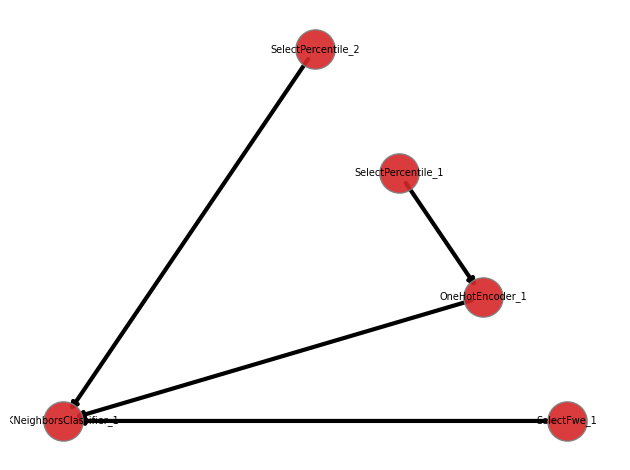

In [17]:
#plot the best pipeline
est.fitted_pipeline_.plot()